In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
%matplotlib inline
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.utils import to_categorical
import keras.regularizers as regularizers
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from utils import *

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dat = load_preprocessed(simple=True,merge_keys=['stages','pows'])
all_data = load_preprocessed(simple=True)
scaler = StandardScaler()
oh_encoder = OneHotEncoder()
scaled_X = scaler.fit_transform(dat['pows'])
labels = dat['stages_simple']
trans_dat = scaled_X
oh_Y = oh_encoder.fit_transform(labels.reshape(-1,1)).toarray()
ex_weight = get_inverse_freq_weights(dat['stages_simple'],sqrt=True)

In [3]:
groups = [ [i]*len(d['pows']) for i,d in zip(np.arange(len(all_data)),all_data) ]
groups = np.concatenate(groups,axis=0)
groups.shape

(7534,)

In [4]:
def get_partition(total, test_frac=0.2, return_bool_mask=False):
    num_total = total
    num_samples = int(test_frac*num_total)
    sample_frac = np.random.choice(num_total,num_samples,replace=False)
    bool_frac = np.bincount(sample_frac,minlength=num_total).astype(np.bool)
    if return_bool_mask:
        return (~bool_frac,bool_frac)
    else:
        return (np.arange(num_total)[bool_frac],np.arange(num_total)[~bool_frac])

In [5]:
pt_masks = [groups==i for i in np.arange(9)]
pt_samples = [oh_Y[m].shape[0] for m in pt_masks]

## Sample 80/20 splits across all patients and combine them all together

In [6]:
splits = [get_partition(num,return_bool_mask=True) for num in pt_samples]
train_bools = [s[0] for s in splits]
test_bools = [s[1] for s in splits]
train_idxs = np.concatenate(train_bools,axis=0)
test_idxs = np.concatenate(test_bools,axis=0)

In [7]:
train_idxs.astype(np.int).sum()

6030

In [8]:
mod_params = dict(
    layer_spec=[32],
    activ='relu',
    optim='nadam',
    num_labels=3
)
mod = feedforward(**mod_params)

In [9]:
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


In [10]:
X = scaled_X[train_idxs]
Y = oh_Y[train_idxs]
Y_w = ex_weight[train_idxs]
mod.fit(X,Y,
        batch_size=128,
        epochs=300,
        sample_weight=Y_w,
        verbose=0)
X_test = scaled_X[test_idxs]
Y_test = oh_Y[test_idxs]
print(mod.evaluate(X_test,Y_test))

1504/1504 [==============================] - 0s 43us/step
[0.38756399252947343, 0.886968085106383]


In [11]:
acc = [mod.evaluate(scaled_X[m][test_idxs],oh_Y[m][test_idxs]) for m,test_idxs in zip(pt_masks,test_bools)]

153/153 [==============================] - 0s 46us/step


In [12]:
acc

[[0.45487584575774176, 0.8518518553209052],
 [0.43183417549950587, 0.8908296943231441],
 [0.30408075026103426, 0.9261083737969986],
 [0.3572428751874853, 0.911111111552627],
 [0.34963754345388975, 0.9485294117647058],
 [0.25657273968346683, 0.9568345323741008],
 [0.2913411021987094, 0.9113924058177804],
 [0.6090419403748748, 0.7283950617283951],
 [0.39325160839978385, 0.8758169946327709]]

(0.3333, 1)

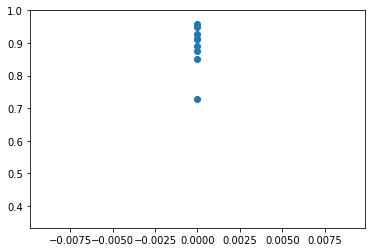

In [14]:
plt.scatter(np.zeros(9),np.array(acc)[:,1])
plt.ylim(0.3333,1)